In [23]:
import pandas as pd 
import json 
import numpy as np 
import matplotlib.pyplot as plt 

%matplotlib inline

# Sun and Weather Data set-up

- Sunspot Numbers 
- F10.7 cm Radio Flux Progression

In [3]:
observed_solar_cycle_indicies = pd.read_json('https://services.swpc.noaa.gov/json/solar-cycle/observed-solar-cycle-indices.json')
predicted_solar_cycle_data = pd.read_json('https://services.swpc.noaa.gov/json/solar-cycle/predicted-solar-cycle.json')
space_weather_ops = pd.read_json('https://services.swpc.noaa.gov/json/solar-cycle/swpc_observed_ssn.json')

In [4]:
def clean_solar_df(df):
    if 'Obsdate' in df.columns: 
        df.set_index('Obsdate', inplace = True)
        df.index = pd.DatetimeIndex(df.index)
    if 'time-tag' in df.columns: 
        df.set_index('time-tag', inplace = True)
        df.index = pd.DatetimeIndex(df.index)
    return df

observed_solar_cycle_indicies = clean_solar_df(observed_solar_cycle_indicies)
predicted_solar_cycle_data = clean_solar_df(predicted_solar_cycle_data)
space_weather_ops = clean_solar_df(space_weather_ops)
space_weather_ops.to_csv('data/space_weather.csv')
observed_solar_cycle_indicies.to_csv('data/solar_cycle.csv')

In [5]:
radioFluxVals = pd.read_html('https://spaceweather.gc.ca/forecast-prevision/solar-solaire/solarflux/sx-5-mavg-en.php')[0]
def clean_radio(d):
    df = d.copy()
    df['Date'] = df[['Year', 'Month']].astype(str).agg('-'.join, axis=1)
    df.index = pd.to_datetime(df['Date'])
    return df.drop(columns = ['Date'])
radioFluxVals = clean_radio(radioFluxVals)
radioFluxVals.to_csv('data/radioFlux.csv')

In [6]:
sunspotNumbers = pd.read_csv('data/sunSpot.csv', sep = ';', 
                names = ['Year', 'Month', 'Day', 'FractionalDate', 'SunspotNumber','Sigma', 'Nobs','Revised'])
def clean_sunspot(d):
    df = d.copy()
    df['Date'] = df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1)
    df.index = pd.to_datetime(df['Date'])
    return df.drop(columns = ['Date'])
sunspotNumbers = clean_sunspot(sunspotNumbers)


In [7]:
sunspotNumbers

,Year,Month,Day,FractionalDate,SunspotNumber,Sigma,Nobs,Revised
Date,,,,,,,,
1818-01-01,1818,1,1,1818.001,-1,-1.0,0,1
1818-01-02,1818,1,2,1818.004,-1,-1.0,0,1
1818-01-03,1818,1,3,1818.007,-1,-1.0,0,1
1818-01-04,1818,1,4,1818.010,-1,-1.0,0,1
1818-01-05,1818,1,5,1818.012,-1,-1.0,0,1
...,...,...,...,...,...,...,...,...
2022-05-27,2022,5,27,2022.401,60,10.6,43,0
2022-05-28,2022,5,28,2022.404,44,6.5,31,0
2022-05-29,2022,5,29,2022.407,45,10.0,32,0


# Pulling in some weather data 
1. Generate some lattitude and longitude data

In [8]:
from citipy import citipy
# Create a set of random latitude and longitude combinations.
lats = np.random.uniform(low=-90.000, high=90.000, size=1000)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1000)
lat_lngs = zip(lats, lngs)
cities = []

In [9]:
for lat, lng in lat_lngs:
    city = citipy.nearest_city(lat, lng).city_name
    if city not in cities:
        cities.append(city)

len(cities)

453

In [21]:
import requests
from futures import openWeatherKey

url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=" + openWeatherKey

In [24]:
import time
from datetime import datetime
from meteostat import Point, Daily

In [ ]:
# Load in CSV of cities, and their coordinates. Add in the part of the globe (North & South)
cdf = pd.read_csv('data/worldcities.csv')
cdf = cdf[['country','city','lat', 'lng']]
cdf['Hemisphere'] = np.where(cdf['lat']>=0,'North', 'South' )
cdf.set_index('country', inplace=True)

start = radioFluxVals.index.min()
end = radioFluxVals.index.max()

d = {}
df = cdf.loc['United States'].head(50)
for x in df.values:
    # City Lat, Lng, Hemisphere
    x = list(x)
    dpoint = Point(x[1], x[2])
    out = Daily(dpoint, start, end).fetch()
    out['Lat'] = x[1]
    out['Lng'] = x[2]
    d[x[0]] = out

In [37]:
type(df.values[0][2])

float

In [53]:
for i in d.keys():
    df = d[i].reset_index()
    df['time'] = str(df['time'])
    d[i] = d[i].to_dict()

In [48]:
import json 

with open('data/city_temp.json', 'w') as fp:
    json.dump(d, fp,  indent=4)

In [12]:
print(list(d.keys()))
print(d['Los Angeles'].columns.to_list())
print(radioFluxVals.columns.to_list())
print(observed_solar_cycle_indicies.columns.to_list())
print(sunspotNumbers.columns.to_list())
print(space_weather_ops.columns.to_list())

['New York', 'Los Angeles', 'Chicago', 'Miami', 'Dallas', 'Philadelphia', 'Houston', 'Atlanta', 'Washington', 'Boston', 'Phoenix', 'Seattle', 'San Francisco', 'Detroit', 'San Diego', 'Minneapolis', 'Tampa', 'Denver', 'Brooklyn', 'Queens', 'Riverside', 'Baltimore', 'Las Vegas', 'Portland', 'San Antonio', 'St. Louis', 'Sacramento', 'Orlando', 'San Jose', 'Cleveland', 'Pittsburgh', 'Austin', 'Cincinnati', 'Kansas City', 'Manhattan', 'Indianapolis', 'Columbus', 'Charlotte', 'Virginia Beach', 'Bronx', 'Milwaukee', 'Providence', 'Jacksonville', 'Salt Lake City', 'Nashville', 'Richmond', 'Memphis', 'Raleigh', 'New Orleans', 'Louisville']
['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'Lat', 'Lng']
['Year', 'Month', 'Observed Flux', 'Adjusted Flux', 'Absolute Flux']
['ssn', 'smoothed_ssn', 'observed_swpc_ssn', 'smoothed_swpc_ssn', 'f10.7', 'smoothed_f10.7']
['Year', 'Month', 'Day', 'FractionalDate', 'SunspotNumber', 'Sigma', 'Nobs', 'Revised']
['swpc_ssn']



 (212,) (212,)
The r-squared is: -0.115


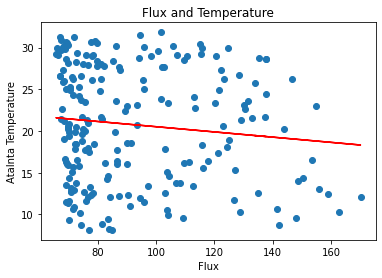

In [13]:
from scipy.stats import linregress
# Create a function to create perform linear regression on the weather data
# and plot a regression line and the equation with the data.  
def plot_linear_regression(x_values, y_values, title, y_label, x_label,text_coordinates = (10,40)):
    
    # Run regresson on hemisphere weather data.
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    
    # Calculate the regression line "y values" from the slope and intercept.
    regress_values = x_values * slope + intercept
    # Get the equation of the line.
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # Create a scatter plot and plot the regression line.
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,"r")
    # Annotate the text for the line equation.
    plt.annotate(line_eq, text_coordinates, fontsize=15, color="red")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    print(f"The r-squared is: {rvalue:.3f}")


regdf = d['Austin'].copy().fillna(0)
regdf = regdf.resample('M').mean()
tmp = radioFluxVals['Observed Flux'].resample('M').mean()

y = regdf['tavg']
X = tmp.loc[regdf.index.min():]
print('\n', X.shape, y.shape)
    
plot_linear_regression(X,y,'Flux and Temperature','Atalnta Temperature','Flux')

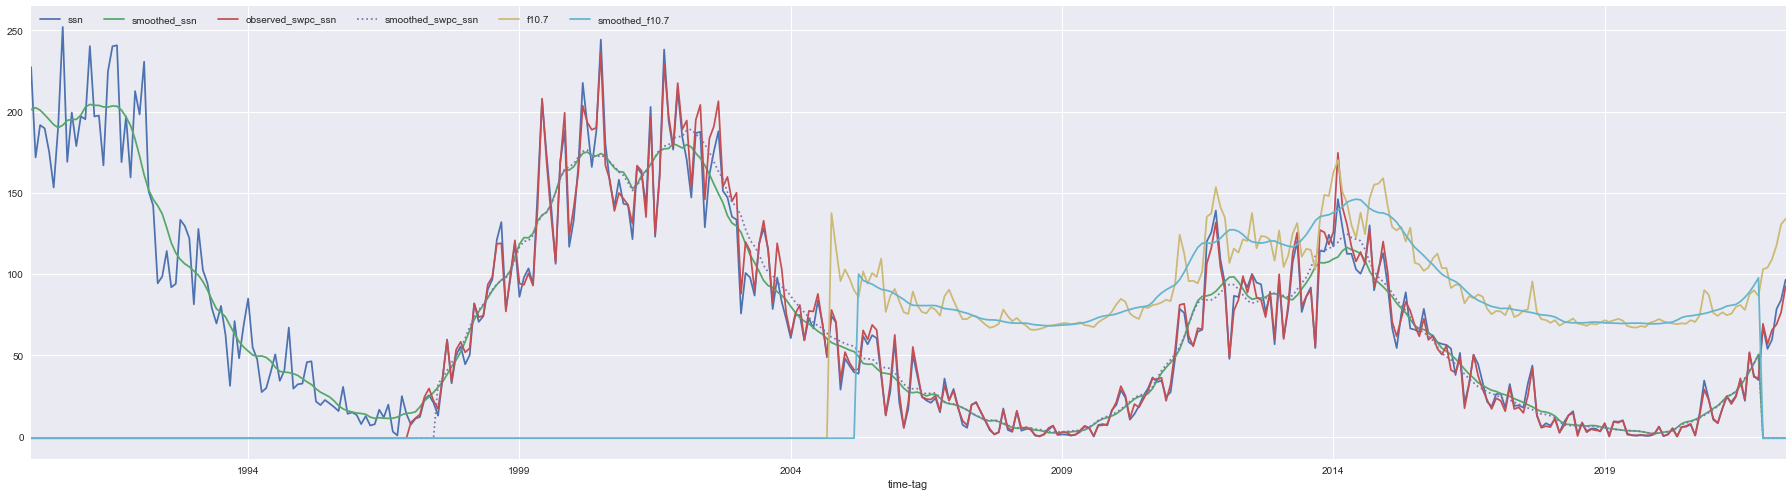

In [25]:
def plot_all_cols(d, ncols = None):
    df = d.copy()
    cols = df.columns.to_list()
    if ncols == None: 
        ncols = len(cols)
    num_colors = len(cols)
    plt.style.use('seaborn')
    linestyle_str = ['solid', 'dotted', 'solid', 'dashed'] * num_colors
    for i, x in enumerate(cols): 
        df[x].plot(figsize = (25,7), linestyle = linestyle_str[np.random.randint(num_colors)]).legend(loc="upper left",ncol = ncols)
    plt.tight_layout()

t = observed_solar_cycle_indicies.loc['1990-01-01':,]
plot_all_cols(t)


In [15]:
d['Atlanta']

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,Lat,Lng
time,,,,,,,,,,,,
2004-10-01,22.2,16.1,27.8,0.0,NaN,NaN,5.8,NaN,1019.1,0.0,33.7627,-84.4224
2004-10-02,23.3,18.9,27.8,0.0,NaN,NaN,4.7,NaN,1021.3,0.0,33.7627,-84.4224
2004-10-03,22.2,17.2,26.7,0.0,NaN,NaN,11.2,NaN,1020.6,0.0,33.7627,-84.4224
2004-10-04,20.6,13.3,27.2,0.0,NaN,321.0,11.9,NaN,1020.5,0.0,33.7627,-84.4224
2004-10-05,20.6,13.9,26.7,0.0,NaN,NaN,7.6,NaN,1022.3,0.0,33.7627,-84.4224
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-27,16.3,7.8,24.4,0.0,NaN,353.0,7.2,NaN,1020.8,NaN,33.7627,-84.4224
2022-04-28,17.4,7.2,25.6,0.0,NaN,67.0,6.0,NaN,1019.9,NaN,33.7627,-84.4224
2022-04-29,18.3,10.0,26.1,0.0,0.0,50.0,5.8,NaN,1018.5,NaN,33.7627,-84.4224


{'tavg': {Timestamp('2004-10-01 00:00:00', freq='D'): 22.2,
  Timestamp('2004-10-02 00:00:00', freq='D'): 23.3,
  Timestamp('2004-10-03 00:00:00', freq='D'): 22.2,
  Timestamp('2004-10-04 00:00:00', freq='D'): 20.6,
  Timestamp('2004-10-05 00:00:00', freq='D'): 20.6,
  Timestamp('2004-10-06 00:00:00', freq='D'): 19.4,
  Timestamp('2004-10-07 00:00:00', freq='D'): 19.4,
  Timestamp('2004-10-08 00:00:00', freq='D'): 17.8,
  Timestamp('2004-10-09 00:00:00', freq='D'): 19.4,
  Timestamp('2004-10-10 00:00:00', freq='D'): 20.0,
  Timestamp('2004-10-11 00:00:00', freq='D'): 21.7,
  Timestamp('2004-10-12 00:00:00', freq='D'): 20.6,
  Timestamp('2004-10-13 00:00:00', freq='D'): 16.1,
  Timestamp('2004-10-14 00:00:00', freq='D'): 15.0,
  Timestamp('2004-10-15 00:00:00', freq='D'): 12.2,
  Timestamp('2004-10-16 00:00:00', freq='D'): 15.0,
  Timestamp('2004-10-17 00:00:00', freq='D'): 18.3,
  Timestamp('2004-10-18 00:00:00', freq='D'): 19.4,
  Timestamp('2004-10-19 00:00:00', freq='D'): 18.3,
  Ti